# 2D Gaussian Splatting implemented in python with a few lines of code



This code implements the renderer of the paper "2D Gaussian Splatting for Geometrically Accurate Radiance Fields".

paper: https://arxiv.org/abs/2403.17888

homepage: https://surfsplatting.github.io/

The cuda code is efficient and good, but it would be more readable with a pure pytorch/python code so readers can have better understanding without needing looking into the cuda implementation. Reader can also implement it with other preferred programming language.

This code is built upon many great repos:

torch-splatting: https://github.com/hbb1/torch-splatting

3DGS: https://github.com/graphdeco-inria/gaussian-splatting

gsplat: https://github.com/nerfstudio-project/gsplat

## Math utils

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
DEVICE = "cpu"

In [11]:
def build_rotation(r):
    norm = torch.sqrt(r[:,0]*r[:,0] + r[:,1]*r[:,1] + r[:,2]*r[:,2] + r[:,3]*r[:,3])

    q = r / norm[:, None]

    R = torch.zeros((q.size(0), 3, 3), device=DEVICE)

    r = q[:, 0]
    x = q[:, 1]
    y = q[:, 2]
    z = q[:, 3]

    R[:, 0, 0] = 1 - 2 * (y*y + z*z)
    R[:, 0, 1] = 2 * (x*y - r*z)
    R[:, 0, 2] = 2 * (x*z + r*y)
    R[:, 1, 0] = 2 * (x*y + r*z)
    R[:, 1, 1] = 1 - 2 * (x*x + z*z)
    R[:, 1, 2] = 2 * (y*z - r*x)
    R[:, 2, 0] = 2 * (x*z - r*y)
    R[:, 2, 1] = 2 * (y*z + r*x)
    R[:, 2, 2] = 1 - 2 * (x*x + y*y)
    return R

def build_scaling_rotation(s, r):
    L = torch.zeros((s.shape[0], 3, 3), dtype=torch.float, device=DEVICE)
    R = build_rotation(r)

    L[:,0,0] = s[:,0]
    L[:,1,1] = s[:,1]
    L[:,2,2] = s[:,2]

    L = R @ L
    return L

# ----> PREGUNTAR
def getProjectionMatrix(znear, zfar, fovX, fovY):
    import math
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

def focal2fov(focal, pixels):
    import math
    return 2*math.atan(pixels/(2*focal))

def homogeneous(points):
    """
    homogeneous points
    :param points: [..., 3]
    """
    return torch.cat([points, torch.ones_like(points[..., :1])], dim=-1)

def homogeneous_vec(vec):
    """
    homogeneous points
    :param points: [..., 3]
    """
    return torch.cat([vec, torch.zeros_like(vec[..., :1])], dim=-1)


## Rendering utils

In [12]:
def alpha_blending(alpha, colors):
  T = torch.cat([torch.ones_like(alpha[-1:]), (1-alpha).cumprod(dim=0)[:-1]], dim=0)
  image = (T * alpha * colors).sum(dim=0).reshape(-1, colors.shape[-1])
  alphamap = (T * alpha).sum(dim=0).reshape(-1, 1)
  return image, alphamap


def alpha_blending_with_gaussians(dist2, colors, opacities, depth_acc, H, W):
    colors = colors.reshape(-1,1,colors.shape[-1])
    depth_acc = depth_acc.T[..., None]
    depth_acc = depth_acc.repeat(1,1,1)

    # evaluate gaussians
    # just for visualization, the actual cut off can be 3 sigma!
    cutoff = 1**2
    dist2 = dist2.T
    gaussians = torch.exp(-0.5*dist2) * (dist2 < cutoff)
    gaussians = gaussians[..., None]
    alpha = opacities.unsqueeze(1) * gaussians

    # accumulate gaussians
    image, _ = alpha_blending(alpha, colors)
    depthmap, alphamap = alpha_blending(alpha, depth_acc)
    depthmap = depthmap / alphamap
    depthmap = torch.nan_to_num(depthmap, 0, 0)
    return image.reshape(H,W,-1), depthmap.reshape(H,W,-1)


## Surface splatting (2D Gaussian splatting)

In [13]:
# Surface splatting (2D Gaussian Splatting)
def setup(means3D, scales, quats, opacities, colors, viewmat, projmat):
    rotations = build_scaling_rotation(scales, quats).permute(0,2,1)

    # 1. Viewing transform
    # Eq.4 and Eq.5
    p_view = (means3D @ viewmat[:3,:3]) + viewmat[-1:,:3]
    uv_view = (rotations @ viewmat[:3,:3])
    M = torch.cat([homogeneous_vec(uv_view[:,:2,:]), homogeneous(p_view.unsqueeze(1))], dim=1)

    T = M @ projmat # T stands for (WH)^T in Eq.9
    # 2. Compute AABB
    #----> PREGUNTAR
    # Homogneous plane is very useful for both ray-splat intersection and bounding box computation
    # we know how to compute u,v given x,y homogeneous plane already; computing AABB is done by a reverse process.
    # i.e compute the x, y s.t. \|hu^4\| = 1 and \|h_v^4\|=1 (distance of gaussian center to plane in the uv space)
    temp_point = torch.tensor([[1.,1., -1.]]).to(DEVICE)
    distance = (temp_point * (T[..., 3] * T[..., 3])).sum(dim=-1, keepdims=True)
    f = (1 / distance) * temp_point
    point_image = torch.cat(
        [(f * T[..., 0] * T[...,3]).sum(dim=-1, keepdims=True),
        (f * T[..., 1] * T[...,3]).sum(dim=-1, keepdims=True),
        (f * T[..., 2] * T[...,3]).sum(dim=-1, keepdims=True)], dim=-1)

    half_extend = point_image * point_image - torch.cat(
        [(f * T[..., 0] * T[...,0]).sum(dim=-1, keepdims=True),
        (f * T[..., 1] * T[...,1]).sum(dim=-1, keepdims=True),
        (f * T[..., 2] * T[...,2]).sum(dim=-1, keepdims=True)], dim=-1)

    radii = half_extend.clamp(min=1e-4).sqrt() * 3 # three sigma
    center = point_image

    # 3. Perform Sorting
    depth = p_view[..., 2] # depth is used only for sorting
    index = depth.sort()[1]
    T = T[index]
    colors = colors[index]
    center = center[index]
    depth = depth[index]
    radii = radii[index]
    opacities = opacities[index]
    return T, colors, opacities, center, depth, radii

def surface_splatting(means3D, scales, quats, colors, opacities, intrins, viewmat, projmat):
    # Rasterization setup
    projmat = torch.zeros(4,4).to(DEVICE)
    projmat[:3,:3] = intrins
    projmat[-1,-2] = 1.0
    projmat = projmat.T
    T, colors, opacities, center, depth, radii = setup(means3D, scales, quats, opacities, colors, viewmat, projmat)

    # Rasterization
    # 1. Generate pixels
    W, H = (intrins[0,-1] * 2).long(), (intrins[1,-1] * 2).long()
    W, H = W.item(), H.item()
    pix = torch.stack(torch.meshgrid(torch.arange(W),
        torch.arange(H), indexing='xy'), dim=-1).to(DEVICE)

    # 2. Compute ray splat intersection # Eq.9 and Eq.10
    x = pix.reshape(-1,1,2)[..., :1]
    y = pix.reshape(-1,1,2)[..., 1:]
    k = -T[None][..., 0] + x * T[None][..., 3]
    l = -T[None][..., 1] + y * T[None][..., 3]
    points = torch.cross(k, l, dim=-1)
    s = points[..., :2] / points[..., -1:]

    # 3. add low pass filter # Eq. 11
    # ----> PREGUNTAR
    # when a point (2D Gaussian) viewed from a far distance or from a slended angle
    # the 2D Gaussian will falls between pixels and no fragment is used to rasterize the Gaussian
    # so we should add a low pass filter to handle such aliasing.
    dist3d = (s * s).sum(dim=-1)
    filtersze = np.sqrt(2) / 2
    dist2d = (1/filtersze)**2 * (torch.cat([x,y], dim=-1) - center[None,:,:2]).norm(dim=-1)**2
    # min of dist2 is equal to max of Gaussian exp(-0.5 * dist2)
    dist2 = torch.min(dist3d, dist2d)
    # dist2 = dist3d
    depth_acc = (homogeneous(s) * T[None,..., -1]).sum(dim=-1)

    # 4. accumulate 2D gaussians through alpha blending # Eq.12
    image, depthmap = alpha_blending_with_gaussians(dist2, colors, opacities, depth_acc, H, W)
    return image, depthmap, center, radii, dist2


In [14]:
# sidenotes
W, H = 3, 3
pix = torch.stack(torch.meshgrid(torch.arange(W),
        torch.arange(H), indexing='xy'), dim=-1)
# pix.reshape(-1,1,2)[..., 1:]

## Volume splatting (3D Gaussian Splatting)

In [15]:
def build_covariance_2d(
    mean3d, cov3d, viewmatrix, tan_fovx, tan_fovy, focal_x, focal_y
):
    import math
    t = (mean3d @ viewmatrix[:3,:3]) + viewmatrix[-1:,:3]
    tz = t[..., 2]
    tx = t[..., 0]
    ty = t[..., 1]

    # Eq.29 locally affine transform
    # perspective transform is not affine so we approximate with first-order taylor expansion
    # notice that we multiply by the intrinsic so that the variance is at the sceen space
    J = torch.zeros(mean3d.shape[0], 3, 3).to(mean3d)
    J[..., 0, 0] = 1 / tz * focal_x
    J[..., 0, 2] = -tx / (tz * tz) * focal_x
    J[..., 1, 1] = 1 / tz * focal_y
    J[..., 1, 2] = -ty / (tz * tz) * focal_y
    W = viewmatrix[:3,:3].T # transpose to correct viewmatrix
    cov2d = J @ W @ cov3d @ W.T @ J.permute(0,2,1)

    # add low pass filter here according to E.q. 32
    filter = torch.eye(2,2).to(cov2d) * 0.0
    return cov2d[:, :2, :2] + filter[None]

def build_covariance_3d(s, r):
    L = build_scaling_rotation(s, r).permute(0,2,1)
    actual_covariance = L @ L.transpose(1, 2)
    return actual_covariance

def projection_ndc(points, viewmatrix, projmatrix):
    points_o = homogeneous(points) # object space
    points_h = points_o @ viewmatrix @ projmatrix # screen space # RHS
    p_w = 1.0 / (points_h[..., -1:] + 0.000001)
    p_proj = points_h * p_w
    p_view = points_o @ viewmatrix
    in_mask = p_view[..., 2] >= 0.2
    return p_proj, p_view, in_mask

def get_radius(cov2d):
    det = cov2d[:, 0, 0] * cov2d[:,1,1] - cov2d[:, 0, 1] * cov2d[:,1,0]
    mid = 0.5 * (cov2d[:, 0,0] + cov2d[:,1,1])
    lambda1 = mid + torch.sqrt((mid**2-det).clip(min=0.1))
    lambda2 = mid - torch.sqrt((mid**2-det).clip(min=0.1))
    return 3.0 * torch.sqrt(torch.max(lambda1, lambda2)).ceil()

def volume_splatting(means3D, scales, quats, colors, opacities, intrins, viewmat, projmat):
    projmat = torch.zeros(4,4).to(DEVICE)
    projmat[:3,:3] = intrins
    projmat[-1,-2] = 1.0
    projmat = projmat.T

    mean_ndc, mean_view, in_mask = projection_ndc(means3D, viewmatrix=viewmat, projmatrix=projmat)

    depths = mean_view[:,2]
    mean_coord_x = mean_ndc[..., 0]
    mean_coord_y = mean_ndc[..., 1]

    means2D = torch.stack([mean_coord_x, mean_coord_y], dim=-1)
    # scales = torch.cat([scales[..., :2], scales[..., -1:]*1e-2], dim=-1)
    cov3d = build_covariance_3d(scales, quats)

    W, H = (intrins[0,-1] * 2).long().item(), (intrins[1,-1] * 2).long().item()
    fx, fy = intrins[0,0], intrins[1,1]
    tan_fovx = W / (2 * fx)
    tan_fovy = H / (2 * fy)
    cov2d = build_covariance_2d(means3D, cov3d, viewmat, tan_fovx, tan_fovy, fx, fy)
    radii = get_radius(cov2d)

    # Rasterization
    # generate pixels
    pix = torch.stack(torch.meshgrid(torch.arange(H), torch.arange(W), indexing='xy'), dim=-1).to(DEVICE).flatten(0,-2)
    sorted_conic = cov2d.inverse() # inverse of variance
    dx = (pix[:,None,:] - means2D[None,:]) # B P 2
    dist2 = dx[:, :, 0]**2 * sorted_conic[:, 0, 0] + dx[:, :, 1]**2 * sorted_conic[:, 1, 1]+ dx[:,:,0]*dx[:,:,1] * sorted_conic[:, 0, 1]+ dx[:,:,0]*dx[:,:,1] * sorted_conic[:, 1, 0]
    depth_acc = depths[None].expand_as(dist2)

    image, depthmap = alpha_blending_with_gaussians(dist2, colors, opacities, depth_acc, H, W)
    return image, depthmap, means2D, radii, dist2


## Utils for inputs and cameras

In [16]:
def get_inputs(num_points=8):
    length = 0.5
    x = np.linspace(-1, 1, num_points) * length
    y = np.linspace(-1, 1, num_points) * length
    x, y = np.meshgrid(x, y)
    means3D = torch.from_numpy(np.stack([x,y, 0 * np.random.rand(*x.shape)], axis=-1).reshape(-1,3)).to(DEVICE).float()
    quats = torch.zeros(1,4).repeat(len(means3D), 1).to(DEVICE)
    quats[..., 0] = 1. # tangent vectors are the canonical basis 
    scale = length /(num_points-1) 
    scales = torch.zeros(1,3).repeat(len(means3D), 1).fill_(scale).to(DEVICE) # ellipsoids without deformation i.e. circles 
    return means3D, scales, quats

def get_cameras():
    intrins = torch.tensor([[711.1111,   0.0000, 256.0000,   0.0000],
               [  0.0000, 711.1111, 256.0000,   0.0000],
               [  0.0000,   0.0000,   1.0000,   0.0000],
               [  0.0000,   0.0000,   0.0000,   1.0000]]).to(DEVICE)
    c2w = torch.tensor([[-8.6086e-01,  3.7950e-01, -3.3896e-01,  6.7791e-01],
         [ 5.0884e-01,  6.4205e-01, -5.7346e-01,  1.1469e+00],
         [ 1.0934e-08, -6.6614e-01, -7.4583e-01,  1.4917e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]).to(DEVICE)

    width, height = 512, 512
    focal_x, focal_y = intrins[0, 0], intrins[1, 1]
    viewmat = torch.linalg.inv(c2w).permute(1,0)
    FoVx = focal2fov(focal_x, width)
    FoVy = focal2fov(focal_y, height)
    projmat = getProjectionMatrix(znear=0.2, zfar=1000, fovX=FoVx, fovY=FoVy).transpose(0,1).to(DEVICE)
    projmat = viewmat @ projmat
    return intrins, viewmat, projmat, height, width


## Visualization of the 2DGS v.s 3DGS

Our 2DGS fits well to a surface.

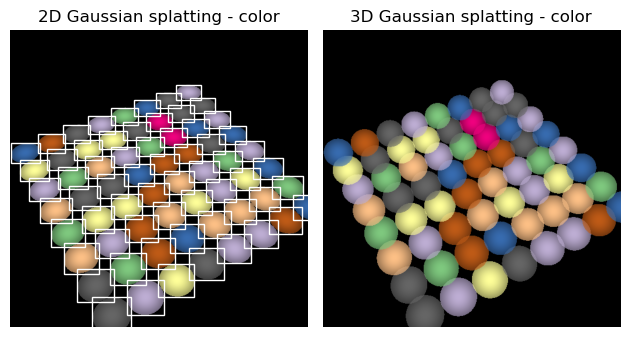

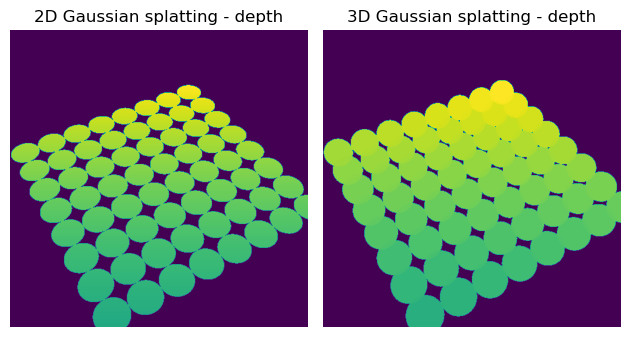

In [17]:
# Make inputs
num_points1=8
means3D, scales, quats = get_inputs(num_points=num_points1)
intrins, viewmat, projmat, height, width = get_cameras()
intrins = intrins[:3,:3]
colors = matplotlib.colormaps['Accent'](np.random.randint(1,64, 64)/64)[..., :3]
colors = torch.from_numpy(colors).to(DEVICE)

opacity = torch.ones_like(means3D[:,:1])
image1, depthmap1, center1, radii1, dist1 = surface_splatting(means3D, scales, quats, colors, opacity, intrins, viewmat, projmat)
image2, depthmap2, center2, radii2, dist2 = volume_splatting(means3D, scales, quats, colors, opacity, intrins, viewmat, projmat)

# Visualize 3DGS and 2DGS
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

from matplotlib.patches import Rectangle
point_image = center1.cpu().detach().numpy()
half_extend = radii1.cpu().numpy() * 1/3 # only show one sigma
lb = np.floor(point_image - half_extend)[..., :2]
hw = np.ceil(2*(half_extend)[..., :2])

ax1.set_aspect('equal')
ax1.set_axis_off()
ax1.set_title('2D Gaussian splatting - color')
ax2.set_aspect('equal')
ax2.set_axis_off()
ax2.set_title('3D Gaussian splatting - color')
ax1.set_aspect('equal')
ax1.set_axis_off()

ax3.set_title('2D Gaussian splatting - depth')
ax3.set_axis_off()
ax3.set_aspect('equal')
ax4.set_axis_off()
ax4.set_title('3D Gaussian splatting - depth')
fig1.tight_layout()
fig2.tight_layout()
# visualize AABB
for k in range(len(half_extend)):
    ax1.add_patch(Rectangle(lb[k], hw[k, 0], hw[k, 1], facecolor='none', edgecolor='white'))
    # ax3.add_patch(Rectangle(lb[k], hw[k, 0], hw[k, 1], facecolor='none', edgecolor='white'))

img1 = image1.cpu().numpy()
img2 = image2.cpu().numpy()
ax1.imshow(img1)
ax2.imshow(img2)

img1 = depthmap1.cpu().numpy()
img2 = depthmap2.cpu().numpy()

ax3.imshow(img1)
ax4.imshow(img2)

plt.savefig('test1.png', transparent=True, dpi=300)

## 2DGS V.S flatten 3DGS (setting last scale to be very small)

Our 2DGS rasterizer is **perspective correct** and **depth accurate**, with the depth gradient consistent to the the normal direction.

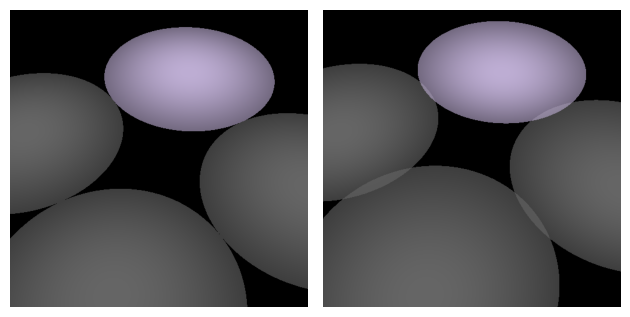

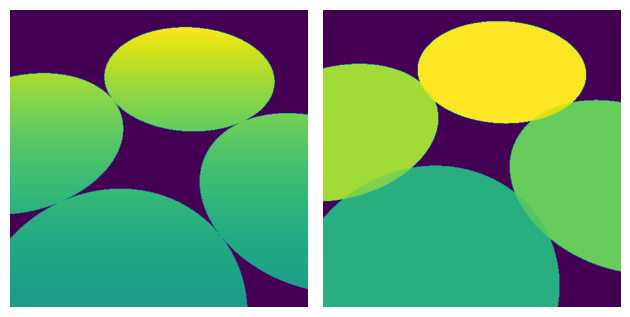

In [18]:
# reduce num of points to give a close look
num_points2=2
means3D, scales, quats = get_inputs(num_points=num_points2)
scales[:,-1] = 0e-6
colors = torch.cat([colors[:num_points2, :], colors[num_points1:num_points1+num_points2, :]], dim=0)

opacity = torch.ones_like(means3D[:,:1])

image1, depthmap1, center1, radii1, dist1 = surface_splatting(means3D, scales, quats, colors, opacity, intrins, viewmat, projmat)
image2, depthmap2, center2, radii2, dist2 = volume_splatting(means3D, scales, quats, colors, opacity, intrins, viewmat, projmat)

# Visualize 3DGS and 2DGS
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

from matplotlib.patches import Rectangle
point_image = center1.cpu().detach().numpy()
half_extend = radii1.cpu().numpy()
lb = np.floor(point_image - half_extend)[..., :2]
hw = np.ceil(2*(half_extend)[..., :2])

ax1.set_aspect('equal')
ax1.set_axis_off()
# ax1.set_title('2D Gaussian splatting - color')
ax2.set_aspect('equal')
ax2.set_axis_off()
# ax2.set_title('3D Gaussian splatting - color')
ax1.set_aspect('equal')
ax1.set_axis_off()

# ax3.set_title('2D Gaussian splatting - depth')
ax3.set_axis_off()
ax3.set_aspect('equal')
ax4.set_axis_off()
# ax4.set_title('3D Gaussian splatting - depth')
fig1.tight_layout()
fig2.tight_layout()

img1 = image1.cpu().numpy()
img2 = image2.cpu().numpy()
ax1.imshow(img1)
ax2.imshow(img2)

img1 = depthmap1.cpu().numpy()
img2 = depthmap2.cpu().numpy()

ax3.imshow(img1)
ax4.imshow(img2)

plt.savefig('test2.png', transparent=True, dpi=300)

you can see that the flatten 3d Gaussian has perspective distortion and the depth is constant within a splat.